# Hypothesis Functionality

## Goals
We want a hypothesis that is:
- Simple. As few nodes as possible.
- Probable. Should have a high probability of being true

## Important Functions
- Write the Graph
- Learn the CPT Table
- ObserveData: Should be done after CPT Table is created but before hypothesis testing
- findBestExplanation given the observed data and the graph

In [109]:
from similarityfunctions import *
import networkx as nx
from itertools import permutations

In [110]:
# add observations to a graph
def observeData(graph, true_nodes, false_nodes):
    nodes = graph.nodes()
    for i in nodes:
        if i in true_nodes:
            graph.nodes[i]['value'] = 1
        elif i in false_nodes:
            graph.nodes[i]['value'] = 0
        else:
            graph.nodes[i]['value'] = None

In [111]:
class CPT(object):
    """
    Defines a CPT Class
    """
    def __init__(self, num_parents):
        self.num_parents = num_parents
        self.CPTable = self.make_table()
        
    def make_table(self):
        CPTable = {}
        if self.num_parents > 0:
            for i in range(2**self.num_parents):
                CPTable[bin(i)] = 0.0
        else:
            CPTable['self'] = 0.0
        return CPTable
    
    def add_entry(self, parent_values, prob):
        # values of nodes sorted in alphabetical order
        key = ''
        for i in parent_values:
            key += str(i)
        self.CPTable[bin(int(key, 2))] = prob 
    
    def add_entry_self(self, prob):
        self.CPTable['self'] = prob
    
    def get_entry(self, parent_values, value):
        key = ''
        for i in parent_values:
            key += str(i)
        return self.CPTable[bin(int(key, 2))][value]
    
    def get_entry_bin(self, parent_bin, value):
        return self.CPTable[parent_bin][value]
    
    def get_entry_self(self, value):
        return self.CPTable['self'][value]
    
    def get_table(self):
        return self.CPTable

In [112]:
from itertools import product
def calculateMarginalProbability(blanket, knodes):
    sorted_nodes = sorted(blanket.nodes())
    # want to calculate P(hyp | obs)
    # first, calculate marginal probability of P(hyp, obs, nodes)
    
    unodes = [item for item in sorted_nodes if (not item in knodes)]
    keys = list(product(range(2), repeat=len(unodes)))
    prob = 0
    for i in keys:
        p = 1
        for x in sorted_nodes:
            # find the parent values of a node
            parents = sorted(list(blanket.predecessors(x)))
            # if it has parents, get the key and get the probability
            if parents:
                # get the parents:
                parent_values = []
                for z in parents:
                    if z in knodes:
                        parent_values.append(blanket.node[z]['value'])
                    else:
                        parent_values.append(i[unodes.index(z)])
                
                parents_key = bin(int(''.join(map(str, parent_values)), 2))
                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, i[unodes.index(x)])
            # if it doesn't have parents, get the entry for itself based on the node value
            else:
                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_self(blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_self(i[unodes.index(x)])
        prob += p
    return prob

In [113]:
def calculateTotalMarginalProbability(blanket, hyp, obs):
    all_obs = []
    all_obs += obs
    all_obs.append(hyp)
    num_prob = calculateMarginalProbability(blanket, all_obs)
    denom_prob = calculateMarginalProbability(blanket, obs)
    return num_prob / denom_prob

## Testing Things
### Making the graph! 
- Based off the example found [HERE](https://www.ics.uci.edu/~rickl/courses/cs-171/2012-wq-cs171/2012-wq-cs171-lecture-slides/2012wq171-17-BayesianNetworks.pdf)

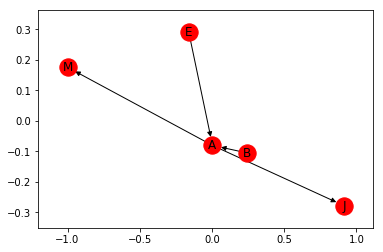

In [114]:
dg = nx.DiGraph()
dg.add_nodes_from(['B', 'E', 'A', 'M', 'J'])
dg.add_weighted_edges_from([('B','A', .94002),('E','A', .29066),('A', 'M',.7),('A','J',.9)])
nx.draw_networkx(dg)

### Learning the CPTable

In [115]:
# burglar
cpt_B = CPT(0)
cpt_B.add_entry_self((1-.001, .001))
dg.node['B']['CPT'] = cpt_B
# earthquake
cpt_E = CPT(0)
cpt_E.add_entry_self((1-.002, .002))
dg.node['E']['CPT'] = cpt_E
#alarm
cpt_A = CPT(2)
cpt_A.add_entry([1, 1], (1-.95, .95))
cpt_A.add_entry([1, 0], (1-.94, .94))
cpt_A.add_entry([0, 1], (1-.29, .29))
cpt_A.add_entry([0, 0], (1-.001, .001))
dg.node['A']['CPT'] = cpt_A
#john calls
cpt_J = CPT(1)
cpt_J.add_entry([1], (1-.9, .9))
cpt_J.add_entry([0], (1-.05, .05))
dg.node['J']['CPT'] = cpt_J
#mary calls
cpt_M = CPT(1)
cpt_M.add_entry([1], (1-.7, .7))
cpt_M.add_entry([0], (1-.01, .01))
dg.node['M']['CPT'] = cpt_M

### Observe the table

In [121]:
observeData(dg, ['M'], [])

### Finding probabilities (fingers crossed!)

In [122]:
#calculateTotalMarginalProbability(dg, 'B', ['M', 'J'])

## Finding the best hypothesis

In [123]:
# Finds all possible hypothesis
def findHypotheses(graph, observed_nodes):
    hyps = []
    for i in graph.nodes():
        children = get_all_children(graph, i, {}, 1)
        if all(item in children.keys() for item in observed_nodes):
            hyps.append(i)
    return hyps

# Finds a bunch of hypothesis. Does nothing yet
def findBestExplanation(graph, observed_nodes):
    hyps = findHypotheses(graph, observed_nodes)
    current_best = (None, 0)
    for i in hyps:
        graph.nodes[i]['value'] = 1
        prob = calculateTotalMarginalProbability(graph, i, observed_nodes)
        graph.nodes[i]['value'] = None
        if prob > current_best[1]:
            current_best = (i, prob)
        print((i, prob))
    return current_best

In [124]:
# given that the alarm went off, and mary and john both called, which explanation is best?
findBestExplanation(dg, ['M'])

('B', 0.05611745403891494)
('E', 0.03588091528645574)
('A', 0.15009011774975964)


('A', 0.15009011774975964)

## Cost Functions
- What do we want to prioritize? 


## Stuff we're probably not using

In [90]:
# adds new true nodes and new false nodes to the graph and then checks for contradictions
# only finds direct contraidctions? Should talk with group about this.
import copy 
def findContradictions(graph, new_true_nodes, new_false_nodes, threshold=.5):
    new_g = copy.deepcopy(graph)
    observeData(new_g, new_true_nodes, new_false_nodes)
    edge_attrs = nx.get_edge_attributes(new_g, 'weight')
    for i in new_g.nodes():
        if 'observed' in new_g.nodes.data()[i]:
            if new_g.nodes.data()[i]['observed'] is True:
                for x in edge_attrs:
                    print(x, x[1], new_g.nodes.data()[x[1]], edge_attrs[x])
                    if 'observed' in new_g.nodes.data()[x[1]]:
                        if x[0] == i and new_g.nodes.data()[x[1]]['observed'] is False and edge_attrs[x] >= threshold:
                            return (i, True, x[1], False, edge_attrs[x])
    return "No contradictions found"

In [96]:
# sees if some nodes are independent based on the nodes we are conditioning on
# we are only checking for *direct* conditions. chains are not accounted for
# since in baysien networks edges are "direct dependence." Should double-check this.
def independenceChecker(graph, conditions, nodes):
    edges = nx.get_edge_attributes(graph, 'weight')
    for i in edges:
        if i[1] in nodes and not i[0] in conditions:
            return False
    return True

In [ ]:
def getMarkovBlanket(graph, obs, hyp):
    #generates a new graph (markov blanket) based on the graph, observations, and hypothesis
    #get all parent nodes
    edge_attrs = nx.get_edge_attributes(graph, 'weight')
    new_graph = nx.DiGraph()
    new_graph.add_node(hyp)
    new_graph.add_nodes_from(obs)
    for i in edge_attrs:
        if i[0] in obs or i[0] == hyp:
            new_graph.add_node(i[1])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
        if i[1] in obs or i[1] == hyp:
            new_graph.add_node(i[0])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
    return new_graph